In [1]:
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, Utils
from SimPEG import DataMisfit, Inversion, Regularization, Problem, Survey
from SimPEG.Utils import mkvc
import numpy as np
import scipy.sparse as sp
%pylab inline

Populating the interactive namespace from numpy and matplotlib


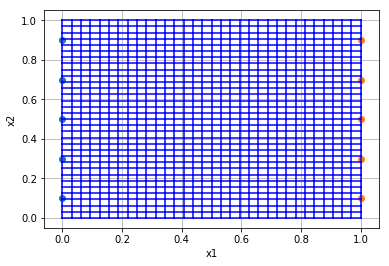

In [2]:
mesh = Mesh.TensorMesh([32,32])
Tx = np.c_[np.zeros(5), np.linspace(0.1,0.9,5)]
Rx = np.c_[np.ones(5), np.linspace(0.1,0.9,5)]

mesh.plotGrid()
plt.scatter(Tx[:,0],Tx[:,1])
plt.scatter(Rx[:,0],Rx[:,1])


In [3]:
# Define a tomography problem class. Most what we need to forward and invert will come from the LinearProblem
# Mostly need to define the line integral through cells
class TomoProblem(Problem.LinearProblem):
    
    def __init__(self, mesh, **kwargs):

        assert mesh.dim == 2, 'Only tested on 2D mesh'
        Problem.BaseProblem.__init__(self, mesh, **kwargs)
        
    @property
    def G(self):
        if not self.ispaired:
            raise Exception('Need to pair!')

        if getattr(self, '_G', None) is None:
            self._G = self.lineIntegral()

        return self._G
    
    def lineIntegral(self):
        
        # Assign value to G
        G = np.zeros((self.survey.nD, self.mesh.nC))
        
        count = 0
        for tx in self.survey.srcList:
            
            rxLocs = tx.rxList[0].locs.tolist()
            for rx in rxLocs:

                dlCell, inCell = self.cellPath(mkvc(tx.loc), rx)
            
                for ind, path in zip(inCell, dlCell):
                    G[count,ind] += path
                
                count += 1
        return G
    
    # Compute lengths
    def cellPath(self, txLoc, rxLoc):
        pts = np.c_[txLoc, rxLoc].T

        # Get equation of the line
        a = (txLoc[1]-rxLoc[1]) / (txLoc[0]-rxLoc[0])
        b = txLoc[1] - a * txLoc[0]
        
        # Add X intercepts
        pts = np.r_[pts, np.c_[self.mesh.vectorNx, a * self.mesh.vectorNx + b]]
        
        # Get Y intercepts
        pts = np.r_[pts, np.c_[(self.mesh.vectorNy - b) / a, self.mesh.vectorNy]]

        # Keep only values inside mesh
        pts = pts[self.mesh.isInside(pts)]
        
        # Sort points
        pts = pts[np.argsort(pts[:,0]),:]
        # Get midpoints
        mids = (pts[1:,:] + pts[:-1,:]) / 2.
        
        # Get lengths and index of cell
        dlCell = np.linalg.norm(pts[1:,:] - pts[:-1,:], axis=1).tolist()
        inCell = Utils.closestPoints(self.mesh, mids).tolist()

        return dlCell, inCell
    
class LinearSurvey(Survey.BaseSurvey):
    """Base Magnetics Survey"""

    rxLoc = None  #: receiver locations
    rxType = None  #: receiver type
    
    def __init__(self, srcList, **kwargs):
        self.srcList = srcList
        Survey.BaseSurvey.__init__(self, **kwargs)
        
    def eval(self, u):
        return u


In [4]:
prob = TomoProblem(mesh)

In [5]:
src = []
# Create source and receivers
for ii in range(Tx.shape[0]):
    rec = [Survey.BaseRx(Rx,'rx')]
    src += [Survey.BaseSrc(rec, loc=Tx[ii,:])]

survey = LinearSurvey(src)
survey.pair(prob)

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
C:\Users\DominiqueFournier\Documents\GIT\SimPEG\discretize\discretize\TensorMesh.py:291: RuntimeWarning: invalid value encountered in greater_equal
  (pts[:, i] >= tensor.min()-TOL) &
C:\Users\DominiqueFournier\Documents\GIT\SimPEG\discretize\discretize\TensorMesh.py:292: RuntimeWarning: invalid value encountered in less_equal
  (pts[:, i] <= tensor.max()+TOL)


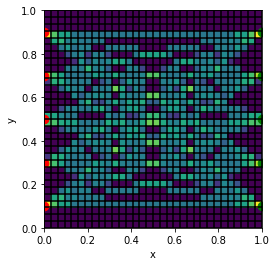

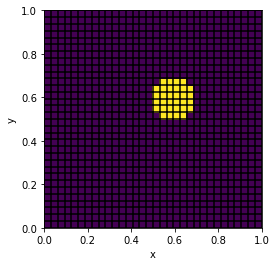

In [6]:
wr = sum(prob.G**2.,axis=0)**0.5 + 1e-8
wr /= wr.max()

fig, axs = plt.figure(), plt.subplot()
im = mesh.plotImage(wr, ax = axs, clim=np.r_[0.0, wr.max()], grid=True)
axs.set_aspect('equal')
plt.scatter(Tx[:,0],Tx[:,1],75,c='r')
plt.scatter(Rx[:,0],Rx[:,1],75,c='g')

fig, axs = plt.figure(), plt.subplot()
# Create a simple model
m = np.zeros(mesh.nC)
m[Utils.ModelBuilder.getIndicesSphere(np.r_[0.6,0.6],0.1,mesh.gridCC)] = 0.5
axs.set_aspect('equal')

im = mesh.plotImage(m, ax = axs, clim=np.r_[0.0, 0.5], grid=True)


In [7]:
# Make data
d = prob.fields(m)

survey.dobs = d

In [8]:
import ipywidgets as widgets
import time
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./(d**0.*1e-2)

def invInteract():
#     fig, axs = plt.figure(figsize=(10,8)), plt.subplot(1,2,1)
    def plotModel(model, model_l2, p_s, eps_p):
        fig = plt.figure(figsize=(12,5))
        ax1 = plt.subplot(1,3,1)
        ax2 = plt.subplot(1,3,2)
        ax3 = plt.subplot(1,3,3)
        im = mesh.plotImage(model, ax = ax2, clim=np.r_[0.0, 0.25], grid=True)
        im = mesh.plotImage(model_l2, ax = ax1, clim=np.r_[0.0, 0.25], grid=True)
        
        mVal = np.sort(np.abs(model))
        
        ax4 = ax3.twinx()
        
        ax3.hist(np.abs(model_l2),25)
        ax3.hist(mVal,25, color='r')
        ax4.plot(mVal, mVal/(mVal**2. + eps_p**2.)**(1-p_s/2),'r')
        ax1.set_aspect('equal'), ax1.set_title('Model l2')
        ax2.set_aspect('equal'), ax2.set_title('Model lp')
        ax3.set_title('Hist(m) and d_phim'), ax3.set_xlim([0,model_l2.max()])
        plt.show()
        
    def invSetter(p_s,p_xy,log_eps_p):
        # % Create inversion objects
        reg = Regularization.Sparse(mesh, mapping=Maps.IdentityMap(nP=mesh.nC))
        reg.mref = np.zeros(mesh.nC)
        reg.cell_weights = wr
        reg.norms = np.r_[p_s,p_xy,p_xy]
        reg.eps_p, reg.eps_q = 10**(log_eps_p), 10**(log_eps_p)

        opt = Optimization.ProjectedGNCG(maxIter=30,
                                         lower=-np.inf,upper=np.inf,
                                         maxIterLS = 20, maxIterCG= 10, tolCG = 1e-3,
                                        silent = True)

        invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta = beta*10)

        IRLS = Directives.Update_IRLS(f_min_change=1e-2, minGNiter=1, silent=True)
        update_Jacobi = Directives.UpdatePreconditioner()
        # saveModel = Directives.SaveUBCModelEveryIteration(mapping=actvMap)
        # saveModel.fileName = work_dir + dsep + out_dir + 'GRAV'

        saveDict = Directives.SaveOutputDictEveryIteration()
        inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,
                                                              update_Jacobi,])
        
        mrec = inv.run(ml2)

        
        return plotModel(mrec, ml2, p_s, 10**(log_eps_p))
    
    
    # % Create inversion objects
    reg = Regularization.Sparse(mesh, mapping=Maps.IdentityMap(nP=mesh.nC))
    reg.mref = np.zeros(mesh.nC)
    reg.cell_weights = wr

    opt = Optimization.ProjectedGNCG(maxIter=30,
                                     lower=-np.inf,upper=np.inf,
                                     maxIterLS = 20, maxIterCG= 10, tolCG = 1e-3,
                                    silent = True)

    invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

    betaest = Directives.BetaEstimate_ByEig()
    IRLS = Directives.Update_IRLS(f_min_change=1e-4, minGNiter=2, silent=True)
    update_Jacobi = Directives.UpdatePreconditioner()
    saveDict = Directives.SaveOutputDictEveryIteration()
    betaSchedule = Directives.BetaSchedule(coolingFactor = 5., coolingRate = 1)
    target = Directives.TargetMisfit()
    inv = Inversion.BaseInversion(invProb, directiveList=[betaest, betaSchedule, target,
                                                          update_Jacobi,])

    ml2 = inv.run(np.ones(mesh.nC)*1e-4)

    

    beta = invProb.beta
    
    # Run inversion
    Q = widgets.interactive(invSetter,
                              p_s=widgets.FloatSlider(min=0,max=2,step=0.1,value=2.,continuous_update=False),
                              p_xy=widgets.FloatSlider(min=0,max=2,step=0.1,value=2.,continuous_update=False),
                              log_eps_p=widgets.FloatSlider(min=-6,max=-1,step=0.5,value=-2,continuous_update=False))
    
    
    return Q


SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [9]:
Q = invInteract()
display(Q)